# Installing & Configuring Pyspark

In [ ]:
!pip3 -q install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Importing the Dataset

In [ ]:
datapath = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip
!unzip bank.zip

--2024-06-01 07:13:16--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [  <=>               ] 999.85K  3.32MB/s    in 0.3s    

2024-06-01 07:13:17 (3.32 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("Bank Marketing EDA").getOrCreate()

# Load the dataset
file_path = "/content/bank-full.csv"

In [ ]:
df = spark.read.csv(file_path, header=True, inferSchema=True, sep=';')

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



# EDA Using RDDs

### Converting DataFrame into RDD

In [ ]:
# Convert DataFrame to RDD
rdd = df.rdd

In [ ]:
# Take the first 5 rows
first_five_rows = rdd.take(5)

# Print the first 5 rows
for row in first_five_rows:
    print(row)

Row(job='management', education='tertiary', balance=2143)
Row(job='technician', education='secondary', balance=29)
Row(job='entrepreneur', education='secondary', balance=2)
Row(job='blue-collar', education='unknown', balance=1506)
Row(job='unknown', education='unknown', balance=1)


### 1. Count the Total No. of Rows

In [ ]:
# 1. Count the number of rows
row_count = rdd.count()
print(f"Number of rows: {row_count}")

Number of rows: 45211


### 2. Distinct Values in a Column

In [ ]:
# 2. Count the number of distinct jobs
distinct_jobs = rdd.map(lambda row: row.job).distinct().count()
print(f"Number of distinct jobs: {distinct_jobs}")

Number of distinct jobs: 12


### 3. Basic Statistics on Numeric Columns

In [ ]:
balances = rdd.map(lambda row: row.balance)

# Mean balance
mean_balance = balances.mean()
print(f"Mean balance: {mean_balance:.2f}")

# Max balance
max_balance = balances.max()
print(f"Max balance: {max_balance}")

# Min balance
min_balance = balances.min()
print(f"Min balance: {min_balance}")

Mean balance: 1362.27
Max balance: 102127
Min balance: -8019


### 4. Frequency Distribution of Categorical Columns

In [ ]:
job_counts = rdd.map(lambda row: (row.job, 1)).reduceByKey(lambda x, y: x + y).collect()
for job, count in job_counts:
    print(f"{job}: {count}")

management: 9458
unknown: 288
retired: 2264
unemployed: 1303
student: 938
technician: 7597
entrepreneur: 1487
blue-collar: 9732
admin.: 5171
services: 4154
self-employed: 1579
housemaid: 1240


### 5. Crosstabulation between Two Categorical Columns

In [ ]:
marital_y = rdd.map(lambda row: ((row.marital, row.y), 1)).reduceByKey(lambda x, y: x + y).collect()
for (marital, y), count in marital_y:
    print(f"{marital}, {y}: {count}")

married, no: 24459
single, no: 10878
married, yes: 2755
single, yes: 1912
divorced, no: 4585
divorced, yes: 622


### 6. Filtering Rows

In [ ]:
high_balance_rdd = rdd.filter(lambda row: row.balance > 1000)
high_balance_count = high_balance_rdd.count()
print(f"Number of rows with balance greater than 1000: {high_balance_count}")

Number of rows with balance greater than 1000: 14631


### 7. Applying Aggregate Function(s)

In [ ]:
# 3. Average balance
total_balance = rdd.map(lambda row: row.balance).reduce(lambda x, y: x + y)
average_balance = total_balance / row_count
print(f"Average balance: {average_balance:.2f}")

Average balance: 1362.27


### 8. Aggregation and Group By

In [ ]:
job_balance_rdd = rdd.map(lambda row: (row.job, (row.balance, 1)))
job_balance_agg = job_balance_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
job_balance_avg = job_balance_agg.mapValues(lambda x: x[0] / x[1]).collect()
for job, avg_balance in job_balance_avg:
    print(f"{job}: {avg_balance:.2f}")

management: 1763.62
unknown: 1772.36
retired: 1984.22
unemployed: 1521.75
student: 1388.06
technician: 1252.63
entrepreneur: 1521.47
blue-collar: 1078.83
admin.: 1135.84
services: 997.09
self-employed: 1647.97
housemaid: 1392.40


### 9. Calculate Correlation between Numeric Columns

In [ ]:
from math import sqrt

# Sum of products of age and balance
sum_product = rdd.map(lambda row: row.age * row.balance).sum()

# Sum of ages and balances
sum_age = rdd.map(lambda row: row.age).sum()
sum_balance = rdd.map(lambda row: row.balance).sum()

# Number of rows
n = rdd.count()

# Sum of squares of age and balance
sum_age_sq = rdd.map(lambda row: row.age ** 2).sum()
sum_balance_sq = rdd.map(lambda row: row.balance ** 2).sum()

# Calculate correlation
numerator = n * sum_product - sum_age * sum_balance
denominator = sqrt((n * sum_age_sq - sum_age ** 2) * (n * sum_balance_sq - sum_balance ** 2))
correlation = numerator / denominator if denominator != 0 else 0

print(f"Correlation between age and balance: {correlation:.4f}")

Correlation between age and balance: 0.0978


### 10. Top N Records by a Column

In [ ]:
top_balances = rdd.takeOrdered(5, key=lambda row: -row.balance)
for row in top_balances:
    print(row)

Row(age=51, job='management', marital='single', education='tertiary', default='no', balance=102127, housing='no', loan='no', contact='cellular', day=3, month='jun', duration=90, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no')
Row(age=59, job='management', marital='married', education='tertiary', default='no', balance=98417, housing='no', loan='no', contact='telephone', day=20, month='nov', duration=145, campaign=5, pdays=-1, previous=0, poutcome='unknown', y='no')
Row(age=84, job='retired', marital='married', education='secondary', default='no', balance=81204, housing='no', loan='no', contact='telephone', day=28, month='dec', duration=679, campaign=1, pdays=313, previous=2, poutcome='other', y='yes')
Row(age=84, job='retired', marital='married', education='secondary', default='no', balance=81204, housing='no', loan='no', contact='telephone', day=1, month='apr', duration=390, campaign=1, pdays=94, previous=3, poutcome='success', y='yes')
Row(age=60, job='retired', marital=

### 11. Handling Missing Values

In [ ]:
missing_age_count = rdd.filter(lambda row: row.age is None).count()
print(f"Number of missing values in age: {missing_age_count}")

Number of missing values in age: 0


### 12. Calculate the Median Balance

In [ ]:
balances = rdd.map(lambda row: row.balance).sortBy(lambda x: x).zipWithIndex().map(lambda x: (x[1], x[0]))
count = balances.count()
median_balance = balances.lookup(count // 2)[0] if count % 2 == 1 else (balances.lookup(count // 2 - 1)[0] + balances.lookup(count // 2)[0]) / 2
print(f"Median balance: {median_balance}")

Median balance: 448


### 13. Count Unique Values in Each Column

In [ ]:
unique_values = {col: rdd.map(lambda row: getattr(row, col)).distinct().count() for col in df.columns}
for col, count in unique_values.items():
    print(f"Number of unique values in {col}: {count}")

Number of unique values in age: 77
Number of unique values in job: 12
Number of unique values in marital: 3
Number of unique values in education: 4
Number of unique values in default: 2
Number of unique values in balance: 7168
Number of unique values in housing: 2
Number of unique values in loan: 2
Number of unique values in contact: 3
Number of unique values in day: 31
Number of unique values in month: 12
Number of unique values in duration: 1573
Number of unique values in campaign: 48
Number of unique values in pdays: 559
Number of unique values in previous: 41
Number of unique values in poutcome: 4
Number of unique values in y: 2


### 14. Standard Deviation of Numeric Columns

In [ ]:
from math import sqrt

balances = rdd.map(lambda row: row.balance)
mean_balance = balances.mean()
stddev_balance = sqrt(balances.map(lambda x: (x - mean_balance) ** 2).mean())
print(f"Standard deviation of balance: {stddev_balance:.2f}")

Standard deviation of balance: 3044.73


### 15. Top N Jobs with Highest Average Balance

In [ ]:
job_balance_rdd = rdd.map(lambda row: (row.job, (row.balance, 1)))
job_balance_agg = job_balance_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
job_balance_avg = job_balance_agg.mapValues(lambda x: x[0] / x[1])
top_jobs = job_balance_avg.takeOrdered(5, key=lambda x: -x[1])
for job, avg_balance in top_jobs:
    print(f"{job}: {avg_balance:.2f}")

retired: 1984.22
unknown: 1772.36
management: 1763.62
self-employed: 1647.97
unemployed: 1521.75


### 16. Group Data by Age Range

In [ ]:
def age_group(age):
    if age < 30:
        return "<30"
    elif 30 <= age < 40:
        return "30-40"
    elif 40 <= age < 50:
        return "40-50"
    else:
        return "50+"

age_groups = rdd.map(lambda row: (age_group(row.age), 1)).reduceByKey(lambda x, y: x + y).collect()
for group, count in age_groups:
    print(f"Age group {group}: {count}")

Age group 50+: 10194
Age group 30-40: 18089
Age group 40-50: 11655
Age group <30: 5273


### 17. Average Campaign Contacts by Job

In [ ]:
job_campaign_rdd = rdd.map(lambda row: (row.job, (row.campaign, 1)))
job_campaign_agg = job_campaign_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
job_campaign_avg = job_campaign_agg.mapValues(lambda x: x[0] / x[1]).collect()
for job, avg_campaign in job_campaign_avg:
    print(f"{job}: {avg_campaign:.2f}")

management: 2.86
unknown: 3.31
retired: 2.35
unemployed: 2.43
student: 2.30
technician: 2.91
entrepreneur: 2.80
blue-collar: 2.82
admin.: 2.58
services: 2.72
self-employed: 2.85
housemaid: 2.82


### 18. Distribution of Education Levels

In [ ]:
education_counts = rdd.map(lambda row: (row.education, 1)).reduceByKey(lambda x, y: x + y).collect()
for education, count in education_counts:
    print(f"{education}: {count}")

tertiary: 13301
unknown: 1857
primary: 6851
secondary: 23202


### 19. Proportion of Positive Outcomes by Previous Outcome

In [ ]:
outcome_proportion = rdd.map(lambda row: (row.poutcome, (1 if row.y == 'yes' else 0, 1)))
outcome_agg = outcome_proportion.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
outcome_ratio = outcome_agg.mapValues(lambda x: x[0] / x[1]).collect()
for poutcome, ratio in outcome_ratio:
    print(f"{poutcome}: {ratio:.2f}")

unknown: 0.09
other: 0.17
success: 0.65
failure: 0.13


### 20. Relationship between Education and Balance

In [ ]:
education_balance_rdd = rdd.map(lambda row: (row.education, (row.balance, 1)))
education_balance_agg = education_balance_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
education_balance_avg = education_balance_agg.mapValues(lambda x: x[0] / x[1]).collect()
for education, avg_balance in education_balance_avg:
    print(f"{education}: {avg_balance:.2f}")

tertiary: 1758.42
unknown: 1526.75
primary: 1250.95
secondary: 1154.88


### 21. Calculate the Interquartile Range (IQR) for Balance

In [ ]:
def get_percentile(rdd, percentile):
    sorted_rdd = rdd.sortBy(lambda x: x).zipWithIndex().map(lambda x: (x[1], x[0]))
    count = sorted_rdd.count()
    index = int(count * percentile / 100)
    return sorted_rdd.lookup(index)[0]

balances = rdd.map(lambda row: row.balance)
q1 = get_percentile(balances, 25)
q3 = get_percentile(balances, 75)
iqr = q3 - q1
print(f"Interquartile Range (IQR) for balance: {iqr}")

Interquartile Range (IQR) for balance: 1356


### 22. Compute the Mode for a Categorical Column

In [ ]:
job_counts = rdd.map(lambda row: (row.job, 1)).reduceByKey(lambda x, y: x + y)
mode_job = job_counts.max(lambda x: x[1])
print(f"Mode for job: {mode_job[0]} with count {mode_job[1]}")

Mode for job: blue-collar with count 9732


### 23. Calculate the Gini Index for Age

In [ ]:
ages = rdd.map(lambda row: row.age)
n = ages.count()
ages_sorted = ages.sortBy(lambda x: x).zipWithIndex().map(lambda x: (x[1] + 1, x[0]))
numerator = ages_sorted.map(lambda x: (2 * x[0] - n - 1) * x[1]).sum()
denominator = n * ages.sum()
gini_index = numerator / denominator
print(f"Gini Index for age: {gini_index:.4f}")

Gini Index for age: 0.1450


### 24. Conduct Chi-Square Test for Independence

In [ ]:
from scipy.stats import chi2_contingency

# Prepare contingency table
contingency_table = rdd.map(lambda row: ((row.job, row.marital), 1)).reduceByKey(lambda x, y: x + y).collectAsMap()
jobs = list(set(rdd.map(lambda row: row.job).collect()))
maritals = list(set(rdd.map(lambda row: row.marital).collect()))

# Create the table
table = [[contingency_table.get((job, marital), 0) for marital in maritals] for job in jobs]

# Perform chi-square test
chi2, p, dof, ex = chi2_contingency(table)
print(f"Chi-Square Test: chi2={chi2}, p-value={p}, dof={dof}")

Chi-Square Test: chi2=3837.6026593315464, p-value=0.0, dof=22


### 25. Perform One-Hot Encoding on a Categorical Column

In [ ]:
marital_categories = rdd.map(lambda row: row.marital).distinct().collect()
marital_dict = {cat: idx for idx, cat in enumerate(marital_categories)}

def one_hot_encode(row):
    encoded = [0] * len(marital_categories)
    encoded[marital_dict[row.marital]] = 1
    return row + tuple(encoded)

encoded_rdd = rdd.map(one_hot_encode)
encoded_rdd.take(5)

[(58,
  'management',
  'married',
  'tertiary',
  'no',
  2143,
  'yes',
  'no',
  'unknown',
  5,
  'may',
  261,
  1,
  -1,
  0,
  'unknown',
  'no',
  1,
  0,
  0),
 (44,
  'technician',
  'single',
  'secondary',
  'no',
  29,
  'yes',
  'no',
  'unknown',
  5,
  'may',
  151,
  1,
  -1,
  0,
  'unknown',
  'no',
  0,
  1,
  0),
 (33,
  'entrepreneur',
  'married',
  'secondary',
  'no',
  2,
  'yes',
  'yes',
  'unknown',
  5,
  'may',
  76,
  1,
  -1,
  0,
  'unknown',
  'no',
  1,
  0,
  0),
 (47,
  'blue-collar',
  'married',
  'unknown',
  'no',
  1506,
  'yes',
  'no',
  'unknown',
  5,
  'may',
  92,
  1,
  -1,
  0,
  'unknown',
  'no',
  1,
  0,
  0),
 (33,
  'unknown',
  'single',
  'unknown',
  'no',
  1,
  'no',
  'no',
  'unknown',
  5,
  'may',
  198,
  1,
  -1,
  0,
  'unknown',
  'no',
  0,
  1,
  0)]

### 26. Calculate Skewness and Kurtosis for Balance

In [ ]:
from scipy.stats import skew, kurtosis

balances = rdd.map(lambda row: row.balance).collect()
balance_skewness = skew(balances)
balance_kurtosis = kurtosis(balances)
print(f"Skewness of balance: {balance_skewness:.4f}")
print(f"Kurtosis of balance: {balance_kurtosis:.4f}")

Skewness of balance: 8.3600
Kurtosis of balance: 140.7358


### 27. Clubbing Two columns

In [ ]:
from datetime import datetime

# Define a function to combine day and month into a datetime object
def combine_day_month(row):
    day = row.day
    month = row.month
    # Assuming the year is fixed, for example 2024
    date_str = f"{day}-{month}-2024"
    date_obj = datetime.strptime(date_str, "%d-%b-%Y")
    # Return a new row with the combined date
    return row + (date_obj,)

# Map the RDD to add the new combined datetime column
combined_rdd = rdd.map(combine_day_month)

# Define a new schema for the updated RDD
from pyspark.sql import Row
new_schema = df.schema.names + ["day_month_date"]
RowWithDate = Row(*new_schema)

# Convert the updated RDD back to a DataFrame
combined_df = combined_rdd.map(lambda row: RowWithDate(*row)).toDF()

# Show the updated DataFrame
combined_df.select("day", "month", "day_month_date").show(5)

+---+-----+-------------------+
|day|month|     day_month_date|
+---+-----+-------------------+
|  5|  may|2024-05-05 00:00:00|
|  5|  may|2024-05-05 00:00:00|
|  5|  may|2024-05-05 00:00:00|
|  5|  may|2024-05-05 00:00:00|
|  5|  may|2024-05-05 00:00:00|
+---+-----+-------------------+
only showing top 5 rows



### 28. Calculate Conditional Probabilities

In [ ]:
yes_tertiary = rdd.filter(lambda row: row.y == 'yes' and row.education == 'tertiary').count()
total_tertiary = rdd.filter(lambda row: row.education == 'tertiary').count()
conditional_prob = yes_tertiary / total_tertiary if total_tertiary != 0 else 0
print(f"P(y='yes' | education='tertiary') = {conditional_prob:.4f}")

P(y='yes' | education='tertiary') = 0.1501


### 29. Compute the Mutual Information Score

In [ ]:
from sklearn.metrics import mutual_info_score

jobs = rdd.map(lambda row: row.job).collect()
maritals = rdd.map(lambda row: row.marital).collect()
mutual_info = mutual_info_score(jobs, maritals)
print(f"Mutual Information between job and marital: {mutual_info:.4f}")

Mutual Information between job and marital: 0.0437


### 30. Perform Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Extract numeric columns
numeric_rdd = rdd.map(lambda row: (row.age, row.balance, row.duration, row.campaign, row.pdays, row.previous))
numeric_array = np.array(numeric_rdd.collect())

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_array)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"PCA result (first 5 rows): \n{pca_result[:5]}")

Explained variance ratio: [0.99182185 0.00709202]
PCA result (first 5 rows): 
[[  780.7329646      1.43100831]
 [-1333.47014589  -104.68233322]
 [-1360.6116036   -179.62948232]
 [  143.41992391  -166.39560804]
 [-1361.38752239   -57.62795336]]


### 31. Time Series Analysis on Campaign Duration

In [ ]:
from pyspark.sql.functions import to_date, col
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Extract date and duration
df_date_duration = df.select(to_date(df["day"] + "/" + df["month"], "dd/MM").alias("date"), col("duration").cast("int"))

# Create a lagged column to find campaign duration differences
window_spec = Window.orderBy("date")
df_lag = df_date_duration.withColumn("previous_duration", lag("duration", 1).over(window_spec))

# Calculate differences
df_diff = df_lag.withColumn("diff", df_lag["duration"] - df_lag["previous_duration"])
df_diff.show()

+----+--------+-----------------+----+
|date|duration|previous_duration|diff|
+----+--------+-----------------+----+
|NULL|     261|             NULL|NULL|
|NULL|     151|              261|-110|
|NULL|      76|              151| -75|
|NULL|      92|               76|  16|
|NULL|     198|               92| 106|
|NULL|     139|              198| -59|
|NULL|     217|              139|  78|
|NULL|     380|              217| 163|
|NULL|      50|              380|-330|
|NULL|      55|               50|   5|
|NULL|     222|               55| 167|
|NULL|     137|              222| -85|
|NULL|     517|              137| 380|
|NULL|      71|              517|-446|
|NULL|     174|               71| 103|
|NULL|     353|              174| 179|
|NULL|      98|              353|-255|
|NULL|      38|               98| -60|
|NULL|     219|               38| 181|
|NULL|      54|              219|-165|
+----+--------+-----------------+----+
only showing top 20 rows



### 32. Dimensionality Reduction Using PCA

In [ ]:
from pyspark.ml.feature import VectorAssembler, PCA

# Prepare features for PCA
assembler = VectorAssembler(inputCols=["age", "balance", "duration", "campaign"], outputCol="features")
df_features = assembler.transform(df)

# Perform PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_features)
df_pca = pca_model.transform(df_features)

# Show the result
df_pca.select("pca_features").show(truncate=False)

+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[-2143.495408076494,-257.0462596786476]  |
|[-29.29228383669001,-150.93307257329616] |
|[-2.150825905198309,-75.98590789351974]  |
|[-1506.1823631702478,-89.21965362445268] |
|[-1.3749071788355143,-197.98747124470245]|
|[-231.26682153702822,-138.56461742681378]|
|[-447.4073214206836,-216.1696881083821]  |
|[-2.712257204496575,-379.98270844238164] |
|[-121.1113891358361,-49.76041065651512]  |
|[-593.1146337458579,-53.89770465011772]  |
|[-270.4212471593464,-221.49112370710566] |
|[-390.26082451299493,-136.27427574218856]|
|[-6.967631753319736,-516.9719768714614]  |
|[-71.15004745349259,-70.85219542399666]  |
|[-162.3387295316229,-173.6851106395798]  |
|[-229.66533890792354,-352.56333403490476]|
|[-13.195306754057656,-97.96229764316122] |
|[-52.089127911507134,-37.88744526348257] |
|[-60.4225828744009,-218.8715072338476]   |
|[-0.11042161140046991,-53.98963

### 33. Custom Aggregation: Median Calculation

In [ ]:
from pyspark.sql import Row

# Extract education and balance
education_balance_rdd = rdd.map(lambda row: (row[3], float(row[5])))

# Custom aggregation to find median
def calculate_median(iterator):
    values = sorted(iterator)
    length = len(values)
    if length % 2 == 0:
        return (values[length // 2 - 1] + values[length // 2]) / 2.0
    else:
        return values[length // 2]

median_rdd = education_balance_rdd.groupByKey().mapValues(calculate_median)
median_rdd.collect()

[('tertiary', 577.0),
 ('unknown', 568.0),
 ('primary', 403.0),
 ('secondary', 392.0)]

### 34. Collaborative Filtering using Alternating Least Squares (ALS)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.mllib.recommendation import ALS, Rating
from pyspark.sql.functions import monotonically_increasing_id

df = df.select("job", "education", "balance")

rdd1 = df.rdd

job_index = rdd1.map(lambda row: row["job"]).distinct().zipWithIndex().collectAsMap()
education_index = rdd1.map(lambda row: row["education"]).distinct().zipWithIndex().collectAsMap()

job_index_broadcast = spark.sparkContext.broadcast(job_index)
education_index_broadcast = spark.sparkContext.broadcast(education_index)

indexed_rdd = rdd1.map(lambda row: Rating(job_index_broadcast.value[row["job"]],
                                        education_index_broadcast.value[row["education"]],
                                        row["balance"]))

(training_rdd, test_rdd) = indexed_rdd.randomSplit([0.8, 0.2])

rank = 10
num_iterations = 10
model = ALS.train(training_rdd, rank, num_iterations)

test_data = test_rdd.map(lambda r: (r[0], r[1]))
predictions = model.predictAll(test_data)

rates_and_preds = test_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions.map(lambda r: ((r[0], r[1]), r[2])))

mse = rates_and_preds.map(lambda r: (r[1][0] - r[1][1]) ** 2).mean()
print(f"Mean Squared Error = {mse}")

predictions.take(10)

Mean Squared Error = 9360506.433866061


[Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086),
 Rating(user=4, product=0, rating=1606.4246954766086)]

### 35. Calculating Entropy of Categorical Columns

In [ ]:
import math

def entropy(rdd_column):
    counts = rdd_column.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
    total_count = counts.map(lambda x: x[1]).sum()
    ent = counts.map(lambda x: (x[1] / total_count) * math.log(x[1] / total_count, 2)).sum()
    return -ent

job_entropy = entropy(rdd.map(lambda row: row.job))
education_entropy = entropy(rdd.map(lambda row: row.education))

print(f"Entropy of job column: {job_entropy}")
print(f"Entropy of education column: {education_entropy}")

Entropy of job column: 3.055352981989424
Entropy of education column: 1.61490199754348


### 36. Computing Point Biserial Correlation

In [ ]:
import math

binary_rdd = rdd.map(lambda row: (row.balance, 1 if row.default == 'yes' else 0))

def point_biserial_correlation(rdd, continuous_col_index, binary_col_index):
    continuous_data = rdd.map(lambda row: (row[continuous_col_index], row[binary_col_index]))

    mean_y = continuous_data.map(lambda x: x[0]).mean()
    n1_rdd = continuous_data.filter(lambda x: x[1] == 1)
    n0_rdd = continuous_data.filter(lambda x: x[1] == 0)

    mean_y1 = n1_rdd.map(lambda x: x[0]).mean()
    mean_y0 = n0_rdd.map(lambda x: x[0]).mean()

    n1 = n1_rdd.count()
    n0 = n0_rdd.count()

    if n0 == 0 or n1 == 0:
        raise ValueError("The binary column must contain both 0s and 1s.")

    s = continuous_data.map(lambda x: x[0]).stdev()

    if s == 0:
        raise ValueError("The standard deviation of the continuous column is zero.")

    r_pb = (mean_y1 - mean_y0) * math.sqrt(n1 * n0) / (n1 + n0) / s
    return r_pb

corr = point_biserial_correlation(binary_rdd, 0, 1)
print(f"Point Biserial Correlation: {corr}")

Point Biserial Correlation: -0.06674505711363106


### 37. Pairwise Pearson Correlation Between Continuous Columns (Age, Balance, Duration)

In [ ]:
from pyspark.mllib.stat import Statistics

continuous_data = rdd.map(lambda row: [row.age, row.balance, row.duration])
correlation_matrix = Statistics.corr(continuous_data, method="pearson")
print("Correlation matrix:\n", correlation_matrix)

Correlation matrix:
 [[ 1.          0.09778274 -0.00464843]
 [ 0.09778274  1.          0.02156038]
 [-0.00464843  0.02156038  1.        ]]


### 38. Logistic Regression on Binary Classification Problem

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

labeled_data = rdd.map(lambda row: LabeledPoint(float(row.y == 'yes'), Vectors.dense([row.age, row.balance, row.duration])))
training_rdd, test_rdd = labeled_data.randomSplit([0.8, 0.2])

model = LogisticRegressionWithLBFGS.train(training_rdd)

predictions = model.predict(test_rdd.map(lambda x: x.features))
labels_and_preds = test_rdd.map(lambda lp: lp.label).zip(predictions)
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_rdd.count())

print(f"Logistic Regression Model Accuracy: {accuracy}")

Logistic Regression Model Accuracy: 0.8869993287088834


# EDA Using Spark DataFrame

### 1. Summary Statistics

In [ ]:
# 1. Show basic statistics
df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+-----------------+-----+------------------+-----------------+------------------+------------------+--------+-----+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|              day|month|          duration|         campaign|             pdays|          previous|poutcome|    y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+-----------------+-----+------------------+-----------------+------------------+------------------+--------+-----+
|  count|             45211|  45211|   45211|    45211|  45211|             45211|  45211|45211|   45211|            45211|45211|             45211|            45211|             45211|             45211|   45211|45211|
|   mean| 40.93621021432837|   NULL|    NULL|     NULL|   NULL|1362.2720576850766|   NULL| NULL|    NULL|15.806418791886

### 2. Count of Differnet Jobs

In [ ]:
# 2. Group by job and count
df.groupBy("job").count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 9458|
|      retired| 2264|
|      unknown|  288|
|self-employed| 1579|
|      student|  938|
|  blue-collar| 9732|
| entrepreneur| 1487|
|       admin.| 5171|
|   technician| 7597|
|     services| 4154|
|    housemaid| 1240|
|   unemployed| 1303|
+-------------+-----+



### 3. Average Balance

In [ ]:
# 3. Average balance
df.select("balance").groupBy().avg().show()

+------------------+
|      avg(balance)|
+------------------+
|1362.2720576850766|
+------------------+



### 4. Show the First Few Rows

In [ ]:
df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|  5|  may|     19

### 5. Column Data Types

In [ ]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string')]

### 6. Count the Number of Rows

In [ ]:
row_count = df.count()
print(f"Total number of rows: {row_count}")

Total number of rows: 45211


### 7. Count Distinct Values

In [ ]:
distinct_jobs = df.select("job").distinct().count()
print(f"Number of distinct jobs: {distinct_jobs}")

Number of distinct jobs: 12


### 8. Filter Rows

In [ ]:
df.filter(df.balance > 1000).show(5)

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58| management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 47|blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 51| management| married| tertiary|     no|  10635|    yes|  no|unknown|  5|  may|     336|       1|   -1|       0| unknown| no|
| 44|   services|divorced|secondary|     no|   2586|    yes|  no|unknown|  5|  may|     160|       1|   -1|       0| unknown| no|
| 54|blue-collar| married|secondary|     no|   1291|    yes|  no|unknown|  5|  may|     26

### 9. Group By and Aggregate

In [ ]:
df.groupBy("marital").avg("balance").show()

+--------+------------------+
| marital|      avg(balance)|
+--------+------------------+
|divorced|1178.8722873055501|
| married|1425.9255897699713|
|  single|1301.4976544175138|
+--------+------------------+



### 10. Calculate Correlation

In [ ]:
correlation = df.stat.corr("balance", "age")
print(f"Correlation between balance and age: {correlation}")

Correlation between balance and age: 0.09778273937134817


### 11. Create New Columns

In [ ]:
from pyspark.sql.functions import log

df = df.withColumn("balance_log", log(df.balance))
df.select("balance", "balance_log").show(5)
df.show(5)

+-------+------------------+
|balance|       balance_log|
+-------+------------------+
|   2143| 7.669961995473577|
|     29| 3.367295829986474|
|      2|0.6931471805599453|
|   1506| 7.317212408359839|
|      1|               0.0|
+-------+------------------+
only showing top 5 rows

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------------------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|       balance_log|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------------------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no| 7.669961995473577|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| u

### 12. Deleting a Column

In [ ]:
print("Schema before dropping column:")
df.printSchema()
df.show(5)

Schema before dropping column:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- balance_log: double (nullable = true)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------------------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|pout

In [ ]:
# Drop the "balance" column
df = df.drop("balance_log")

# Show the schema and first few rows after dropping the column
print("Schema after dropping column:")
df.printSchema()
df.show(5)

Schema after dropping column:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-

### 13. Handling Missing Values

In [ ]:
average_balance = df.select("balance").groupBy().avg().first()[0]
df = df.na.fill({"balance": average_balance})
df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|  5|  may|     19

### 14. Check for Null Values in Each Column

In [ ]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



### 15. Calculate the Percentage of Each Category in a Categorical Column

In [ ]:
total_count = df.count()
df.groupBy("job").count().withColumn("percentage", col("count") / total_count * 100).show()

+-------------+-----+------------------+
|          job|count|        percentage|
+-------------+-----+------------------+
|   management| 9458|20.919687686624936|
|      retired| 2264|5.0076308862887355|
|      unknown|  288|0.6370131162770122|
|self-employed| 1579|3.4925128840326467|
|      student|  938| 2.074716330096658|
|  blue-collar| 9732|21.525734887527374|
| entrepreneur| 1487| 3.289022582999712|
|       admin.| 5171|11.437482028709828|
|   technician| 7597| 16.80343279290438|
|     services| 4154| 9.188029461856628|
|    housemaid| 1240|2.7426953617482472|
|   unemployed| 1303|2.8820419809338436|
+-------------+-----+------------------+



### 16. Find the Minimum and Maximum Values of a Column

In [ ]:
df.selectExpr("min(age)", "max(age)").show()

+--------+--------+
|min(age)|max(age)|
+--------+--------+
|      18|      95|
+--------+--------+



### 17. Calculate the Mean and Standard Deviation of a Numerical Column

In [ ]:
df.selectExpr("mean(duration)", "stddev(duration)").show()

+-----------------+------------------+
|   mean(duration)|  stddev(duration)|
+-----------------+------------------+
|258.1630797814691|257.52781226517095|
+-----------------+------------------+



### 18. Create a New Column Categorizing Age Groups

In [ ]:
from pyspark.sql.functions import when

df = df.withColumn(
    "age_group",
    when(df.age < 30, "young")
    .when((df.age >= 30) & (df.age < 60), "middle-aged")
    .otherwise("senior")
)
df.select("age", "age_group").show(5)

+---+-----------+
|age|  age_group|
+---+-----------+
| 58|middle-aged|
| 44|middle-aged|
| 33|middle-aged|
| 47|middle-aged|
| 33|middle-aged|
+---+-----------+
only showing top 5 rows



### 19. Pivot Table: Average Balance by Job and Marital Status

In [ ]:
df.groupBy("job").pivot("marital").avg("balance").show()

+-------------+------------------+------------------+------------------+
|          job|          divorced|           married|            single|
+-------------+------------------+------------------+------------------+
|   management|1618.0738073807381|1828.1594444444445|1700.2195453003053|
|      retired| 1507.835294117647| 2140.098786828423| 1360.388888888889|
|      unknown|1706.2941176470588| 1788.128078817734|1741.7941176470588|
|self-employed|           2426.35|1644.9486404833838| 1410.365470852018|
|      student|            1101.0|1164.7962962962963| 1403.753986332574|
|  blue-collar| 820.8066666666666|1113.1659012629161|1056.1052631578948|
| entrepreneur|1155.9832402234638|1643.3878504672898| 1248.235294117647|
|       admin.| 878.3333333333334|1281.4095803936132|1020.7390046296297|
|   technician| 924.0486486486486| 1307.399555774926|1283.9381679389312|
|     services|  834.304189435337|1088.8475280432074| 887.3247078464107|
|    housemaid|1573.2228260869565| 1248.17324561403

### 20. Calculate Quartiles for a Numerical Column

In [ ]:
quartiles = df.approxQuantile("balance", [0.25, 0.5, 0.75], 0.05)
print(f"25th percentile: {quartiles[0]}, 50th percentile: {quartiles[1]}, 75th percentile: {quartiles[2]}")

25th percentile: 76.0, 50th percentile: 421.0, 75th percentile: 1172.0


### 21. Visualize the Distribution of a Numerical Column

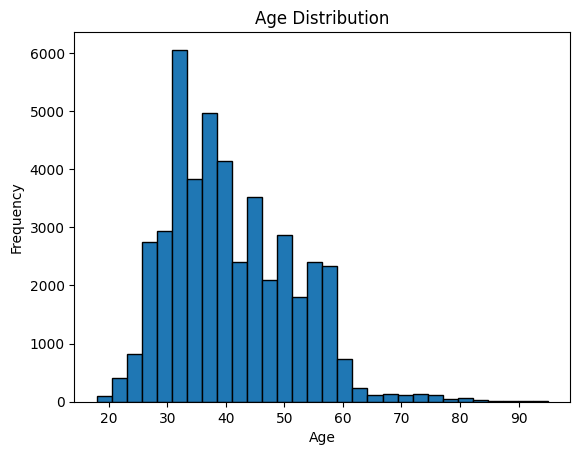

In [ ]:
import matplotlib.pyplot as plt

ages = df.select("age").rdd.flatMap(lambda x: x).collect()
plt.hist(ages, bins=30, edgecolor='k')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

### 22. Cross Tabulation (Contingency Table)

In [ ]:
df.crosstab("education", "y").show()

+-----------+-----+----+
|education_y|   no| yes|
+-----------+-----+----+
|    unknown| 1605| 252|
|   tertiary|11305|1996|
|  secondary|20752|2450|
|    primary| 6260| 591|
+-----------+-----+----+



### 23. Find Rows with Duplicate Values in a Specific Column

In [ ]:
df.groupBy("age").count().filter(col("count") > 1).show()

+---+-----+
|age|count|
+---+-----+
| 31| 1996|
| 85|    5|
| 65|   59|
| 53|  891|
| 78|   30|
| 34| 1930|
| 81|   17|
| 28| 1038|
| 76|   32|
| 27|  909|
| 26|  805|
| 44| 1136|
| 22|  129|
| 47| 1088|
| 52|  911|
| 86|    9|
| 40| 1355|
| 20|   50|
| 57|  828|
| 54|  811|
+---+-----+
only showing top 20 rows



### 24. Heatmap Data Preparation for Correlations

In [ ]:
import pandas as pd

numerical_columns = ["age", "balance", "duration", "campaign", "pdays", "previous"]
corr_data = []

for col1 in numerical_columns:
    row = []
    for col2 in numerical_columns:
        if col1 != col2:
            row.append(df.stat.corr(col1, col2))
        else:
            row.append(1.0)
    corr_data.append(row)

corr_df = pd.DataFrame(corr_data, columns=numerical_columns, index=numerical_columns)
print(corr_df)

               age   balance  duration  campaign     pdays  previous
age       1.000000  0.097783 -0.004648  0.004760 -0.023758  0.001288
balance   0.097783  1.000000  0.021560 -0.014578  0.003435  0.016674
duration -0.004648  0.021560  1.000000 -0.084570 -0.001565  0.001203
campaign  0.004760 -0.014578 -0.084570  1.000000 -0.088628 -0.032855
pdays    -0.023758  0.003435 -0.001565 -0.088628  1.000000  0.454820
previous  0.001288  0.016674  0.001203 -0.032855  0.454820  1.000000


### 25. Word Count on Categorical Columns

In [ ]:
from pyspark.sql.functions import explode, split

df_word_count = df.select(explode(split(col("job"), " ")).alias("word")).groupBy("word").count()
df_word_count.show()

+-------------+-----+
|         word|count|
+-------------+-----+
|   management| 9458|
|      retired| 2264|
|      unknown|  288|
|self-employed| 1579|
|      student|  938|
|  blue-collar| 9732|
| entrepreneur| 1487|
|       admin.| 5171|
|   technician| 7597|
|     services| 4154|
|    housemaid| 1240|
|   unemployed| 1303|
+-------------+-----+



### 26. Calculate Gini Index for a Categorical Column

In [ ]:
from pyspark.sql.functions import col

total_count = df.count()
df_job_counts = df.groupBy("job").count()
df_job_counts = df_job_counts.withColumn("probability", col("count") / total_count)
df_job_counts = df_job_counts.withColumn("p_square", col("probability") ** 2)

gini_index = 1 - df_job_counts.agg({"p_square": "sum"}).first()[0]
print(f"Gini Index for 'job' column: {gini_index}")

Gini Index for 'job' column: 0.8532787710193472


### 27. Bucketize Age Column

In [ ]:
from pyspark.ml.feature import Bucketizer

splits = [0, 30, 60, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="age", outputCol="age_buckets")

df_bucketed = bucketizer.transform(df)
df_bucketed.select("age", "age_buckets").show(5)

+---+-----------+
|age|age_buckets|
+---+-----------+
| 58|        1.0|
| 44|        1.0|
| 33|        1.0|
| 47|        1.0|
| 33|        1.0|
+---+-----------+
only showing top 5 rows



### 28. Time Series Analysis on Subscription Rates

In [ ]:
df.groupBy("day", "month").count().orderBy("month", "day").show()

+---+-----+-----+
|day|month|count|
+---+-----+-----+
|  1|  apr|   47|
|  2|  apr|   50|
|  3|  apr|   62|
|  5|  apr|   19|
|  6|  apr|   72|
|  7|  apr|   84|
|  8|  apr|  110|
|  9|  apr|   86|
| 12|  apr|   23|
| 13|  apr|   78|
| 14|  apr|   93|
| 15|  apr|  108|
| 16|  apr|  284|
| 17|  apr|  593|
| 19|  apr|    9|
| 20|  apr|  634|
| 21|  apr|   42|
| 22|  apr|   50|
| 23|  apr|   41|
| 24|  apr|   15|
+---+-----+-----+
only showing top 20 rows



### 29. Generate a Correlation Matrix for Numerical Columns

In [ ]:
numerical_columns = ["age", "balance", "duration", "campaign", "pdays", "previous"]
corr_matrix = {}

for col1 in numerical_columns:
    for col2 in numerical_columns:
        if col1 != col2:
            corr = df.stat.corr(col1, col2)
            corr_matrix[(col1, col2)] = corr

for key, value in corr_matrix.items():
    print(f"Correlation between {key[0]} and {key[1]}: {value}")

Correlation between age and balance: 0.09778273937134817
Correlation between age and duration: -0.004648428470615698
Correlation between age and campaign: 0.0047603117624537335
Correlation between age and pdays: -0.023758014111728405
Correlation between age and previous: 0.0012883192026691302
Correlation between balance and age: 0.09778273937134817
Correlation between balance and duration: 0.02156038049466894
Correlation between balance and campaign: -0.01457827885076633
Correlation between balance and pdays: 0.003435321868106621
Correlation between balance and previous: 0.016673636728357942
Correlation between duration and age: -0.004648428470615696
Correlation between duration and balance: 0.021560380494668942
Correlation between duration and campaign: -0.08456950273006188
Correlation between duration and pdays: -0.0015647704813435241
Correlation between duration and previous: 0.001203056916700335
Correlation between campaign and age: 0.004760311762453733
Correlation between campaign

### 30. Calculate the Skewness and Kurtosis of a Column

In [ ]:
from pyspark.sql.functions import skewness, kurtosis

df.select(skewness("balance"), kurtosis("balance")).show()

+-----------------+------------------+
|skewness(balance)| kurtosis(balance)|
+-----------------+------------------+
|8.360030947252623|140.73584832577234|
+-----------------+------------------+



### 31. Detect and Handle Outliers

In [ ]:
from pyspark.sql.functions import expr

# Calculate Q1 and Q3
q1, q3 = df.approxQuantile("balance", [0.25, 0.75], 0.05)
iqr = q3 - q1

# Define lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter outliers
df_outliers_removed = df.filter((df.balance >= lower_bound) & (df.balance <= upper_bound))
df_outliers_removed.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|  age_group|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|middle-aged|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|middle-aged|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|middle-aged|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|middle-aged|
| 33| 

### 32. Calculate the Mode Value of a Column

In [ ]:
from pyspark.sql.functions import count

mode_job = df.groupBy("job").count().orderBy(col("count").desc()).first()[0]
print(f"Mode of the 'job' column: {mode_job}")

Mode of the 'job' column: blue-collar


### 33. Text Analysis on Categorical Columns

In [ ]:
from pyspark.sql.functions import explode, split

# Split the "job" column into words and count their occurrences
word_counts = df.select(explode(split(col("job"), " ")).alias("word")).groupBy("word").count().orderBy(col("count").desc())

# Show the most common words
word_counts.show(5)

+-----------+-----+
|       word|count|
+-----------+-----+
|blue-collar| 9732|
| management| 9458|
| technician| 7597|
|     admin.| 5171|
|   services| 4154|
+-----------+-----+
only showing top 5 rows



### 34. K-Means Clustering and Analysis

In [ ]:
from pyspark.ml.clustering import KMeans

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["age", "balance", "duration", "campaign", "pdays", "previous"], outputCol="features")
df_vector = assembler.transform(df)

# Fit the KMeans model
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df_vector)

# Make predictions
predictions = model.transform(df_vector)

# Show the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Show the prediction results
predictions.show(5)

Cluster Centers: 
[4.06306821e+01 6.46855725e+02 2.56227998e+02 2.77402118e+00
 4.02928835e+01 5.67594189e-01]
[4.56375405e+01 2.55013851e+04 2.55970874e+02 2.74433657e+00
 3.26440129e+01 5.43689320e-01]
[4.34885834e+01 6.39350955e+03 2.76630242e+02 2.66891892e+00
 3.98422647e+01 7.03401678e-01]
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----------+--------------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|  age_group|            features|prediction|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----------+--------------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|middle-aged|[58.0,2143.0,261....|         0|
| 44|  

### 35. Time-Series Analysis Using Moving Average

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg

# Define the window specification
window_spec = Window.partitionBy().orderBy("day").rowsBetween(-2, 2)

# Calculate the moving average
df_moving_avg = df.withColumn("moving_avg_duration", avg("duration").over(window_spec))

# Show the results
df_moving_avg.select("day", "duration", "moving_avg_duration").show(5)

+---+--------+-------------------+
|day|duration|moving_avg_duration|
+---+--------+-------------------+
|  1|     602|              373.0|
|  1|     136|             319.25|
|  1|     381|              351.2|
|  1|     158|              287.0|
|  1|     479|              319.2|
+---+--------+-------------------+
only showing top 5 rows



### 36. Principal Component Analysis (PCA)

In [ ]:
from pyspark.ml.feature import PCA

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["age", "balance", "duration", "campaign", "pdays", "previous"], outputCol="features")
df_vector = assembler.transform(df)

# Fit PCA model with 3 principal components
pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_vector)

# Transform the data using the PCA model
df_pca = pca_model.transform(df_vector)

# Show the PCA results
df_pca.select("pca_features").show(5)

+--------------------+
|        pca_features|
+--------------------+
|[-2143.4952809631...|
|[-29.292170469325...|
|[-2.1507127558502...|
|[-1506.1822402731...|
|[-1.3747939712308...|
+--------------------+
only showing top 5 rows



### 37. Anomaly Detection Using Isolation Forest

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Convert relevant features into a single vector
assembler = VectorAssembler(inputCols=["age", "balance", "duration", "campaign", "pdays", "previous"], outputCol="features")
df_vector = assembler.transform(df)

# Fit the Bisecting K-Means model
bisecting_kmeans = BisectingKMeans(k=2, featuresCol="features")
model = bisecting_kmeans.fit(df_vector)

# Make predictions
predictions = model.transform(df_vector)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Show the prediction results
predictions.show(5)

Silhouette with squared euclidean distance = 0.9361412181731162
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----------+--------------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|  age_group|            features|prediction|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----------+--------------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|middle-aged|[58.0,2143.0,261....|         0|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|middle-aged|[44.0,29.0,151.0,...|         0|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|u

### 38. Lift Analysis for Marketing Campaign Effectiveness

In [ ]:
total_count = df.count()
positive_count = df.filter(df.y == "yes").count()

# Calculate lift for each job category
df_lift = df.groupBy("job").agg(
    count("job").alias("segment_count"),
    count(when(df.y == "yes", 1)).alias("positive_segment_count")
)

df_lift = df_lift.withColumn("segment_rate", col("segment_count") / total_count)
df_lift = df_lift.withColumn("positive_rate", col("positive_segment_count") / col("segment_count"))
df_lift = df_lift.withColumn("lift", col("positive_rate") / (positive_count / total_count))

# Show the lift values
df_lift.show()

+-------------+-------------+----------------------+--------------------+-------------------+------------------+
|          job|segment_count|positive_segment_count|        segment_rate|      positive_rate|              lift|
+-------------+-------------+----------------------+--------------------+-------------------+------------------+
|   management|         9458|                  1301| 0.20919687686624935|0.13755550856417847|   1.1758408201352|
|      retired|         2264|                   516| 0.05007630886288735|0.22791519434628976|1.9482461432388176|
|      unknown|          288|                    34|0.006370131162770122|0.11805555555555555|1.0091529064515452|
|self-employed|         1579|                   187| 0.03492512884032647|0.11842938568714376|1.0123484508038298|
|      student|          938|                   269| 0.02074716330096658| 0.2867803837953092|2.4514327721251132|
|  blue-collar|         9732|                   708| 0.21525734887527373|0.07274969173859433|0.6

### 39. Custom Aggregation Function to Analyze Customer Age Groups

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf

# Define a UDF to categorize age groups
def age_group(age):
    if age < 30:
        return "Under 30"
    elif age <= 60:
        return "30-60"
    else:
        return "Above 60"

age_group_udf = udf(age_group)

# Apply the UDF to create a new column
df_age_grouped = df.withColumn("age_group", age_group_udf(col("age")))

# Perform aggregation to analyze behaviors
df_age_analysis = df_age_grouped.groupBy("age_group").agg(
    count("*").alias("total_customers"),
    avg("balance").alias("average_balance"),
    avg(when(col("y") == "yes", 1).otherwise(0)).alias("subscription_rate")
)

# Show the results
df_age_analysis.show()

+---------+---------------+------------------+-------------------+
|age_group|total_customers|   average_balance|  subscription_rate|
+---------+---------------+------------------+-------------------+
| Above 60|           1188| 2678.446127946128| 0.4225589225589226|
| Under 30|           5273| 986.5702636070548| 0.1759908970225678|
|    30-60|          38750|1373.0452387096775|0.09958709677419354|
+---------+---------------+------------------+-------------------+



### 40. Analysis of Contact Duration Distribution by Age Group

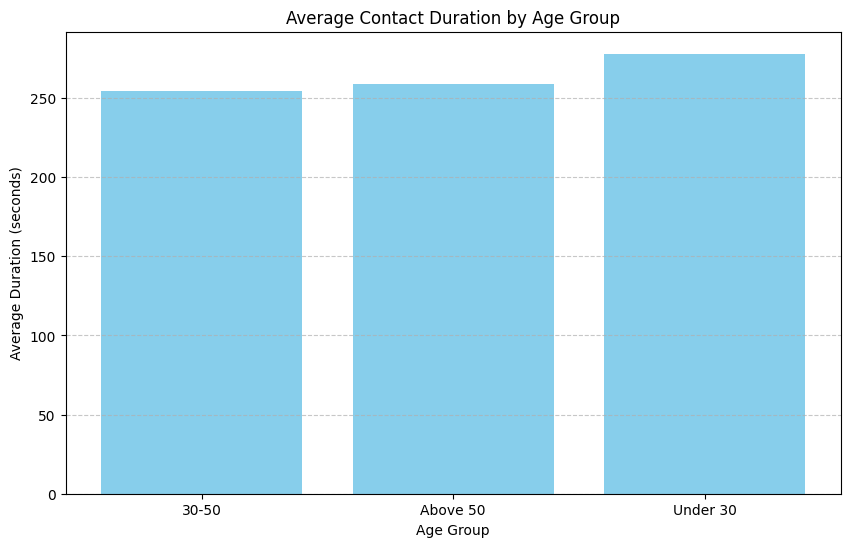

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, expr
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("ContactDurationAnalysis").getOrCreate()

# Load the dataset into a DataFrame
file_path = "/content/bank-full.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True, sep=';')

# Create age groups based on predefined age ranges
df = df.withColumn("age_group",
                   when(col("age") < 30, "Under 30")
                   .when((col("age") >= 30) & (col("age") <= 50), "30-50")
                   .otherwise("Above 50"))

# Group by age group and calculate the average contact duration
age_group_duration = df.groupBy("age_group").agg(expr("avg(duration)").alias("avg_duration"))

# Convert DataFrame to Pandas for plotting
age_group_duration_pd = age_group_duration.toPandas()

# Plot the distribution of contact duration by age group
plt.figure(figsize=(10, 6))
plt.bar(age_group_duration_pd["age_group"], age_group_duration_pd["avg_duration"], color='skyblue')
plt.title("Average Contact Duration by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Duration (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# EDA Using SparkSQL

### SQL Temporary View

In [ ]:
# Register DataFrame as a SQL temporary view
df.createOrReplaceTempView("bank")

### 1. Count the Number of Records

In [ ]:
df.createOrReplaceTempView("bank")
spark.sql("SELECT COUNT(*) FROM bank").show()

+--------+
|count(1)|
+--------+
|   45211|
+--------+



### 2. Show the Schema of the Dataset

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



### 3. Basic Statistics of Numerical Columns

In [ ]:
spark.sql("SELECT AVG(age), AVG(balance), AVG(duration) FROM bank").show()

+-----------------+------------------+-----------------+
|         avg(age)|      avg(balance)|    avg(duration)|
+-----------------+------------------+-----------------+
|40.93621021432837|1362.2720576850766|258.1630797814691|
+-----------------+------------------+-----------------+



### 4. Summary Statistics

In [ ]:
# Basic statistics
spark.sql("SELECT MIN(balance), MAX(balance), AVG(balance), STDDEV(balance) FROM bank").show()

+------------+------------+------------------+------------------+
|min(balance)|max(balance)|      avg(balance)|   stddev(balance)|
+------------+------------+------------------+------------------+
|       -8019|      102127|1362.2720576850766|3044.7658291685243|
+------------+------------+------------------+------------------+



### 5. Distribution of Job Types

In [ ]:
spark.sql("SELECT job, COUNT(*) as count FROM bank GROUP BY job ORDER BY count DESC").show()

+-------------+-----+
|          job|count|
+-------------+-----+
|  blue-collar| 9732|
|   management| 9458|
|   technician| 7597|
|       admin.| 5171|
|     services| 4154|
|      retired| 2264|
|self-employed| 1579|
| entrepreneur| 1487|
|   unemployed| 1303|
|    housemaid| 1240|
|      student|  938|
|      unknown|  288|
+-------------+-----+



### 6. Proportion of Subscription (y)

In [ ]:
spark.sql("SELECT y, COUNT(*) as count FROM bank GROUP BY y").show()

+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



### 7. Average Balance by Marital Status

In [ ]:
spark.sql("SELECT marital, AVG(balance) as avg_balance FROM bank GROUP BY marital").show()

+--------+------------------+
| marital|       avg_balance|
+--------+------------------+
|divorced|1178.8722873055501|
| married|1425.9255897699713|
|  single|1301.4976544175138|
+--------+------------------+



### 8. Maximum and Minimum Age of Customers

In [ ]:
spark.sql("SELECT MAX(age) as max_age, MIN(age) as min_age FROM bank").show()

+-------+-------+
|max_age|min_age|
+-------+-------+
|     95|     18|
+-------+-------+



### 9. Count of Customers with and without Housing Loan

In [ ]:
spark.sql("SELECT housing, COUNT(*) as count FROM bank GROUP BY housing").show()

+-------+-----+
|housing|count|
+-------+-----+
|     no|20081|
|    yes|25130|
+-------+-----+



### 10. Average Duration of Last Contact by Education Level

In [ ]:
spark.sql("SELECT education, AVG(duration) as avg_duration FROM bank GROUP BY education").show()

+---------+------------------+
|education|      avg_duration|
+---------+------------------+
|  unknown|257.31394722670973|
| tertiary|258.51853244116984|
|secondary|258.68575984828897|
|  primary|255.93300248138956|
+---------+------------------+



### 11. Number of Contacts Per Month

In [ ]:
spark.sql("SELECT month, COUNT(*) as count FROM bank GROUP BY month ORDER BY count DESC").show()

+-----+-----+
|month|count|
+-----+-----+
|  may|13766|
|  jul| 6895|
|  aug| 6247|
|  jun| 5341|
|  nov| 3970|
|  apr| 2932|
|  feb| 2649|
|  jan| 1403|
|  oct|  738|
|  sep|  579|
|  mar|  477|
|  dec|  214|
+-----+-----+



### 12. Group By and Count

In [ ]:
# Group by job and count
spark.sql("SELECT job, COUNT(*) AS count FROM bank GROUP BY job ORDER BY count DESC").show()

+-------------+-----+
|          job|count|
+-------------+-----+
|  blue-collar| 9732|
|   management| 9458|
|   technician| 7597|
|       admin.| 5171|
|     services| 4154|
|      retired| 2264|
|self-employed| 1579|
| entrepreneur| 1487|
|   unemployed| 1303|
|    housemaid| 1240|
|      student|  938|
|      unknown|  288|
+-------------+-----+



### 13. Calculating Average

In [ ]:
# Average balance
spark.sql("SELECT AVG(balance) AS avg_balance FROM bank").show()

+------------------+
|       avg_balance|
+------------------+
|1362.2720576850766|
+------------------+



### 14. Count of Customers by Job

In [ ]:
df.createOrReplaceTempView("bank")

job_count = spark.sql("SELECT job, COUNT(*) as count FROM bank GROUP BY job ORDER BY count DESC")
job_count.show()

+-------------+-----+
|          job|count|
+-------------+-----+
|  blue-collar| 9732|
|   management| 9458|
|   technician| 7597|
|       admin.| 5171|
|     services| 4154|
|      retired| 2264|
|self-employed| 1579|
| entrepreneur| 1487|
|   unemployed| 1303|
|    housemaid| 1240|
|      student|  938|
|      unknown|  288|
+-------------+-----+



### 15. Average Age of Customers by Job

In [ ]:
avg_age_by_job = spark.sql("SELECT job, AVG(age) as avg_age FROM bank GROUP BY job ORDER BY avg_age DESC")
avg_age_by_job.show()

+-------------+------------------+
|          job|           avg_age|
+-------------+------------------+
|      retired| 61.62676678445229|
|      unknown|          47.59375|
|    housemaid| 46.41532258064516|
| entrepreneur| 42.19098856758574|
|   unemployed| 40.96162701458174|
|self-employed| 40.48448385053832|
|   management| 40.44956650454642|
|  blue-collar|  40.0440813810111|
|   technician| 39.31459786757931|
|       admin.| 39.28988590214659|
|     services|38.740250361097736|
|      student|26.542643923240938|
+-------------+------------------+



### 16. Subscription Rate by Marital Status

In [ ]:
subscription_by_marital = spark.sql("""
    SELECT marital,
           SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) AS subscription_rate
    FROM bank
    GROUP BY marital
    ORDER BY subscription_rate DESC
""")
subscription_by_marital.show()

+--------+-------------------+
| marital|  subscription_rate|
+--------+-------------------+
|  single| 0.1494917904612979|
|divorced|0.11945458037257538|
| married|0.10123465863158668|
+--------+-------------------+



### 17. Distribution of Education Levels

In [ ]:
education_distribution = spark.sql("SELECT education, COUNT(*) as count FROM bank GROUP BY education ORDER BY count DESC")
education_distribution.show()

+---------+-----+
|education|count|
+---------+-----+
|secondary|23202|
| tertiary|13301|
|  primary| 6851|
|  unknown| 1857|
+---------+-----+



### 18. Average Balance by Education Level

In [ ]:
avg_balance_by_education = spark.sql("SELECT education, AVG(balance) as avg_balance FROM bank GROUP BY education ORDER BY avg_balance DESC")
avg_balance_by_education.show()

+---------+------------------+
|education|       avg_balance|
+---------+------------------+
| tertiary|1758.4164348545223|
|  unknown|1526.7544426494346|
|  primary|1250.9499343161583|
|secondary| 1154.880786139126|
+---------+------------------+



### 19. Relationship between Loan and Subscription

In [ ]:
loan_subscription = spark.sql("""
    SELECT loan,
           SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) AS subscription_rate
    FROM bank
    GROUP BY loan
    ORDER BY subscription_rate DESC
""")
loan_subscription.show()

+----+-------------------+
|loan|  subscription_rate|
+----+-------------------+
|  no|0.12655727342165565|
| yes|0.06681391496410823|
+----+-------------------+



### 20.  Success Rate by Contact Communication Type

In [ ]:
success_by_contact = spark.sql("""
    SELECT contact,
           SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) AS success_rate
    FROM bank
    GROUP BY contact
    ORDER BY success_rate DESC
""")
success_by_contact.show()

+---------+--------------------+
|  contact|        success_rate|
+---------+--------------------+
| cellular| 0.14918900460986853|
|telephone| 0.13420509291121818|
|  unknown|0.040706605222734255|
+---------+--------------------+



### 21. Average Campaign Duration by Outcome

In [ ]:
avg_duration_by_outcome = spark.sql("SELECT y, AVG(duration) as avg_duration FROM bank GROUP BY y ORDER BY avg_duration DESC")
avg_duration_by_outcome.show()

+---+------------------+
|  y|      avg_duration|
+---+------------------+
|yes| 537.2945736434109|
| no|221.18280647262162|
+---+------------------+



### 22. Analyze Age Distribution for Subscribers vs Non-subscribers

In [ ]:
age_distribution = spark.sql("""
    SELECT y,
           age,
           COUNT(*) as count
    FROM bank
    GROUP BY y, age
    ORDER BY age, count DESC
""")
age_distribution.show()

+---+---+-----+
|  y|age|count|
+---+---+-----+
|yes| 18|    7|
| no| 18|    5|
| no| 19|   24|
|yes| 19|   11|
| no| 20|   35|
|yes| 20|   15|
| no| 21|   57|
|yes| 21|   22|
| no| 22|   89|
|yes| 22|   40|
| no| 23|  158|
|yes| 23|   44|
| no| 24|  234|
|yes| 24|   68|
| no| 25|  414|
|yes| 25|  113|
| no| 26|  671|
|yes| 26|  134|
| no| 27|  768|
|yes| 27|  141|
+---+---+-----+
only showing top 20 rows



### 23. Median Balance by Age Group

In [ ]:
df.createOrReplaceTempView("bank")

median_balance_by_age_group = spark.sql("""
    SELECT age_group, PERCENTILE_APPROX(balance, 0.5) as median_balance
    FROM (
        SELECT *,
               CASE
                   WHEN age < 30 THEN 'Under 30'
                   WHEN age BETWEEN 30 AND 50 THEN '30-50'
                   ELSE 'Above 50'
               END as age_group
        FROM bank
    )
    GROUP BY age_group
""")
median_balance_by_age_group.show()

+---------+--------------+
|age_group|median_balance|
+---------+--------------+
|    30-50|           425|
| Above 50|           654|
| Under 30|           339|
+---------+--------------+



### 24. Mode of Contact Method by Job

In [ ]:
mode_contact_by_job = spark.sql("""
    SELECT job, contact, COUNT(*) as count
    FROM bank
    GROUP BY job, contact
    ORDER BY job, count DESC
""").createOrReplaceTempView("contact_counts")

mode_contact_by_job_final = spark.sql("""
    SELECT job, FIRST(contact) as most_common_contact
    FROM contact_counts
    GROUP BY job
""")
mode_contact_by_job_final.show()

+-------------+-------------------+
|          job|most_common_contact|
+-------------+-------------------+
|       admin.|           cellular|
|  blue-collar|           cellular|
| entrepreneur|           cellular|
|    housemaid|           cellular|
|   management|           cellular|
|      retired|           cellular|
|self-employed|           cellular|
|     services|           cellular|
|      student|           cellular|
|   technician|           cellular|
|   unemployed|           cellular|
|      unknown|           cellular|
+-------------+-------------------+



### 25. Average Duration of Calls by Day of the Week

In [ ]:
avg_duration_by_day = spark.sql("""
    SELECT day_of_week, AVG(duration) as avg_duration
    FROM (
        SELECT *,
               CASE
                   WHEN day = 'mon' THEN 'Monday'
                   WHEN day = 'tue' THEN 'Tuesday'
                   WHEN day = 'wed' THEN 'Wednesday'
                   WHEN day = 'thu' THEN 'Thursday'
                   ELSE 'Friday'
               END as day_of_week
        FROM bank
    )
    GROUP BY day_of_week
""")
avg_duration_by_day.show()

+-----------+-----------------+
|day_of_week|     avg_duration|
+-----------+-----------------+
|     Friday|258.1630797814691|
+-----------+-----------------+



### 26. Relationship between Marital Status and Loan Default

In [ ]:
marital_loan_default = spark.sql("""
    SELECT marital,
           SUM(CASE WHEN default = 'yes' THEN 1 ELSE 0 END) / COUNT(*) as default_rate
    FROM bank
    GROUP BY marital
    ORDER BY default_rate DESC
""")
marital_loan_default.show()

+--------+--------------------+
| marital|        default_rate|
+--------+--------------------+
|divorced|0.024582293067025158|
|  single|0.018686473807662238|
| married|0.016462115087822443|
+--------+--------------------+



### 27. Correlation between Balance and Duration

In [ ]:
correlation_balance_duration = spark.sql("""
    SELECT corr(balance, duration) as correlation
    FROM bank
""")
correlation_balance_duration.show()

+-------------------+
|        correlation|
+-------------------+
|0.02156038049466894|
+-------------------+



### 28. Analysis of Customers with Multiple Loans

In [ ]:
multiple_loans = spark.sql("""
    SELECT COUNT(*) as count,
           SUM(CASE WHEN housing = 'yes' AND loan = 'yes' THEN 1 ELSE 0 END) as multiple_loans
    FROM bank
""")
multiple_loans.show()

+-----+--------------+
|count|multiple_loans|
+-----+--------------+
|45211|          4367|
+-----+--------------+



### 29. Age Distribution for Each Education Level

In [ ]:
age_distribution_education = spark.sql("""
    SELECT education, age, COUNT(*) as count
    FROM bank
    GROUP BY education, age
    ORDER BY education, age
""")
age_distribution_education.show()

+---------+---+-----+
|education|age|count|
+---------+---+-----+
|  primary| 18|    3|
|  primary| 19|    9|
|  primary| 20|    6|
|  primary| 21|   10|
|  primary| 22|    8|
|  primary| 23|   17|
|  primary| 24|   19|
|  primary| 25|   25|
|  primary| 26|   56|
|  primary| 27|   69|
|  primary| 28|   73|
|  primary| 29|   94|
|  primary| 30|  124|
|  primary| 31|  139|
|  primary| 32|  179|
|  primary| 33|  167|
|  primary| 34|  166|
|  primary| 35|  191|
|  primary| 36|  182|
|  primary| 37|  195|
+---------+---+-----+
only showing top 20 rows



### 30. Subscription Rate by Contact Duration Group

In [ ]:
subscription_by_duration_group = spark.sql("""
    SELECT duration_group,
           SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) as subscription_rate
    FROM (
        SELECT *,
               CASE
                   WHEN duration < 100 THEN '< 100s'
                   WHEN duration BETWEEN 100 AND 300 THEN '100-300s'
                   ELSE '> 300s'
               END as duration_group
        FROM bank
    )
    GROUP BY duration_group
""")
subscription_by_duration_group.show()

+--------------+--------------------+
|duration_group|   subscription_rate|
+--------------+--------------------+
|        > 300s| 0.28173374613003094|
|        < 100s|0.010537113017530773|
|      100-300s| 0.07734209697024265|
+--------------+--------------------+



### 31. Top 5 Jobs with Highest Average Balance

In [ ]:
top5_jobs_by_balance = spark.sql("""
    SELECT job, AVG(balance) as avg_balance
    FROM bank
    GROUP BY job
    ORDER BY avg_balance DESC
    LIMIT 5
""")
top5_jobs_by_balance.show()

+-------------+------------------+
|          job|       avg_balance|
+-------------+------------------+
|      retired| 1984.215106007067|
|      unknown| 1772.357638888889|
|   management|1763.6168323112709|
|self-employed|1647.9708676377454|
|   unemployed|1521.7459708365311|
+-------------+------------------+



### 32. Influence of Previous Campaign Outcome on Current Subscription

In [ ]:
previous_campaign_influence = spark.sql("""
    SELECT previous,
        SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) as subscription_rate
    FROM bank
    GROUP BY previous
    ORDER BY subscription_rate DESC
""")
previous_campaign_influence.show()

+--------+-------------------+
|previous|  subscription_rate|
+--------+-------------------+
|      58|                1.0|
|      55|                1.0|
|      26|                0.5|
|      10| 0.3880597014925373|
|      30| 0.3333333333333333|
|       8| 0.3023255813953488|
|       6| 0.2996389891696751|
|       5| 0.2636165577342048|
|       7| 0.2634146341463415|
|      14| 0.2631578947368421|
|       9| 0.2608695652173913|
|       3| 0.2574430823117338|
|      29|               0.25|
|      21|               0.25|
|       4|0.23949579831932774|
|      13|0.23684210526315788|
|      11|0.23076923076923078|
|      12|0.22727272727272727|
|       2|0.21652421652421652|
|       1|0.21031746031746032|
+--------+-------------------+
only showing top 20 rows



### 33. Analysis of Subscription Rate by Combining Multiple Attributes

In [ ]:
subscription_multi_attr = spark.sql("""
    SELECT job, education, marital,
           SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) as subscription_rate
    FROM bank
    GROUP BY job, education, marital
    ORDER BY subscription_rate DESC
""")
subscription_multi_attr.show()

+-------------+---------+--------+-------------------+
|          job|education| marital|  subscription_rate|
+-------------+---------+--------+-------------------+
|   unemployed|  unknown|divorced|                1.0|
|      student|  primary| married|                0.5|
|      student|  primary|  single|0.36585365853658536|
| entrepreneur|  unknown|divorced| 0.3333333333333333|
|      student| tertiary|divorced| 0.3333333333333333|
|      retired| tertiary|divorced| 0.3176470588235294|
|      student|secondary|  single| 0.2997946611909651|
|      retired|  primary|divorced| 0.2962962962962963|
|      student| tertiary|  single| 0.2828282828282828|
|      retired|  unknown| married|0.27722772277227725|
|      unknown| tertiary|  single| 0.2727272727272727|
|      student|  unknown|  single|0.26973684210526316|
|      retired| tertiary| married| 0.2677165354330709|
|      retired|secondary|divorced|0.26666666666666666|
|   unemployed| tertiary|  single|0.26119402985074625|
|      stu

### 34. Campaign Success Rate Based on Previous Campaign Outcome and Duration

In [ ]:
success_prev_campaign = spark.sql("""
    SELECT previous,
           SUM(CASE WHEN y = 'yes' AND duration > 200 THEN 1 ELSE 0 END) / COUNT(*) as success_rate_long_calls,
           SUM(CASE WHEN y = 'yes' AND duration <= 200 THEN 1 ELSE 0 END) / COUNT(*) as success_rate_short_calls
    FROM bank
    GROUP BY previous
""")
success_prev_campaign.show()

+--------+-----------------------+------------------------+
|previous|success_rate_long_calls|success_rate_short_calls|
+--------+-----------------------+------------------------+
|      28|                    0.0|                     0.0|
|      26|                    0.0|                     0.5|
|      27|                    0.0|                     0.0|
|      12|     0.1590909090909091|     0.06818181818181818|
|      22|    0.16666666666666666|                     0.0|
|       1|    0.16378066378066378|    0.046536796536796536|
|      13|    0.18421052631578946|     0.05263157894736842|
|      16|                    0.0|                     0.0|
|       6|    0.24548736462093862|     0.05415162454873646|
|       3|    0.20665499124343256|    0.050788091068301226|
|      20|                  0.125|                     0.0|
|      40|                    0.0|                     0.0|
|       5|    0.19389978213507625|     0.06971677559912855|
|      19|    0.18181818181818182|      

### 35. Clustering Age and Balance to Identify Customer Segments

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Assemble features for clustering
assembler = VectorAssembler(inputCols=["age", "balance"], outputCol="features")
df_features = assembler.transform(df)

# Apply KMeans clustering
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df_features)
transformed = model.transform(df_features)

# Show cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Add cluster info to the main DataFrame
df_clustered = transformed.select("age", "balance", "prediction").withColumnRenamed("prediction", "cluster")
df_clustered.createOrReplaceTempView("bank_clustered")

# Analyze clusters
cluster_analysis = spark.sql("""
    SELECT cluster, AVG(age) as avg_age, AVG(balance) as avg_balance
    FROM bank_clustered
    GROUP BY cluster
""")
cluster_analysis.show()

Cluster Centers: 
[ 40.63418782 644.02575795]
[   45.63754045 25501.38511327]
[  43.42936288 6366.95036934]
+-------+------------------+------------------+
|cluster|           avg_age|       avg_balance|
+-------+------------------+------------------+
|      1|45.637540453074436|25501.385113268607|
|      2| 43.42936288088643| 6366.950369344414|
|      0|40.634187823514914| 644.0257579492236|
+-------+------------------+------------------+



### 36. Predictive Analysis: Logistic Regression for Subscription Prediction

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Prepare the data
indexer = StringIndexer(inputCol="y", outputCol="label")
df_indexed = indexer.fit(df).transform(df)

assembler = VectorAssembler(inputCols=["age", "balance", "duration"], outputCol="features")
df_features = assembler.transform(df_indexed)

# Split the data
train, test = df_features.randomSplit([0.7, 0.3], seed=42)

# Apply Logistic Regression
lr = LogisticRegression()
model = lr.fit(train)

# Evaluate the model
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8124474709415499


### 37. Analysis of Interaction Between Contact Duration and Campaign Outcome Over Time

In [ ]:
duration_outcome_time = spark.sql("""
    SELECT month,
           AVG(duration) as avg_duration,
           SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) as subscription_rate
    FROM bank
    GROUP BY month
    ORDER BY month
""")
duration_outcome_time.show()

+-----+------------------+-------------------+
|month|      avg_duration|  subscription_rate|
+-----+------------------+-------------------+
|  apr|298.09890859481584|0.19679399727148705|
|  aug|232.40211301424685|0.11013286377461182|
|  dec|329.32710280373834| 0.4672897196261682|
|  feb|248.29822574556437| 0.1664779161947905|
|  jan| 268.2202423378475|0.10121168923734854|
|  jul| 267.9753444525018|0.09093546047860769|
|  jun| 243.0878112712975|0.10222804718217562|
|  mar|244.40041928721175|  0.519916142557652|
|  may|260.92227226500074|0.06719453726572715|
|  nov|253.14861460957178|0.10151133501259446|
|  oct|288.30216802168025|0.43766937669376693|
|  sep|292.25215889464596|0.46459412780656306|
+-----+------------------+-------------------+



### 38. Identifying High-Risk Customers Based on Multiple Factors

In [ ]:
high_risk_customers = spark.sql("""
    SELECT age, job, balance, default, loan,
           CASE
               WHEN age > 60 AND balance < 0 AND default = 'yes' AND loan = 'yes' THEN 'High Risk'
               ELSE 'Low Risk'
           END as risk_level
    FROM bank
""")
high_risk_customers.show()

+---+------------+-------+-------+----+----------+
|age|         job|balance|default|loan|risk_level|
+---+------------+-------+-------+----+----------+
| 58|  management|   2143|     no|  no|  Low Risk|
| 44|  technician|     29|     no|  no|  Low Risk|
| 33|entrepreneur|      2|     no| yes|  Low Risk|
| 47| blue-collar|   1506|     no|  no|  Low Risk|
| 33|     unknown|      1|     no|  no|  Low Risk|
| 35|  management|    231|     no|  no|  Low Risk|
| 28|  management|    447|     no| yes|  Low Risk|
| 42|entrepreneur|      2|    yes|  no|  Low Risk|
| 58|     retired|    121|     no|  no|  Low Risk|
| 43|  technician|    593|     no|  no|  Low Risk|
| 41|      admin.|    270|     no|  no|  Low Risk|
| 29|      admin.|    390|     no|  no|  Low Risk|
| 53|  technician|      6|     no|  no|  Low Risk|
| 58|  technician|     71|     no|  no|  Low Risk|
| 57|    services|    162|     no|  no|  Low Risk|
| 51|     retired|    229|     no|  no|  Low Risk|
| 45|      admin.|     13|     

### 39. Analysis of Call Durations and Frequency for Different Education Levels

In [ ]:
call_duration_freq_education = spark.sql("""
    SELECT education,
           COUNT(*) as num_calls,
           AVG(duration) as avg_duration
    FROM bank
    GROUP BY education
    ORDER BY num_calls DESC
""")
call_duration_freq_education.show()

+---------+---------+------------------+
|education|num_calls|      avg_duration|
+---------+---------+------------------+
|secondary|    23202|258.68575984828897|
| tertiary|    13301|258.51853244116984|
|  primary|     6851|255.93300248138956|
|  unknown|     1857|257.31394722670973|
+---------+---------+------------------+



### 40. Analysis of Housing Loan Status Over Different Age Groups

In [ ]:
housing_loan_age_group = spark.sql("""
    SELECT age_group,
           SUM(CASE WHEN housing = 'yes' THEN 1 ELSE 0 END) / COUNT(*) as housing_loan_rate
    FROM (
        SELECT *,
               CASE
                   WHEN age < 30 THEN 'Under 30'
                   WHEN age BETWEEN 30 AND 50 THEN '30-50'
                   ELSE 'Above 50'
               END as age_group
        FROM bank
    )
    GROUP BY age_group
""")
housing_loan_age_group.show()

+---------+-------------------+
|age_group|  housing_loan_rate|
+---------+-------------------+
|    30-50|  0.607111429781964|
| Above 50|0.37460831982712045|
| Under 30| 0.5755736772235919|
+---------+-------------------+



### 41. Feature Engineering: Creating a Composite Score for Subscription Likelihood

In [ ]:
# Create a composite score based on selected features
df = df.withColumn("composite_score", col("age") * 0.2 + col("balance") * 0.5 + col("duration") * 0.3)
df.createOrReplaceTempView("bank")

composite_score_analysis = spark.sql("""
    SELECT composite_score,
           SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) / COUNT(*) as subscription_rate
    FROM bank
    GROUP BY composite_score
    ORDER BY composite_score DESC
""")
composite_score_analysis.show()

+------------------+-----------------+
|   composite_score|subscription_rate|
+------------------+-----------------+
|           51100.7|              0.0|
|           49263.8|              0.0|
|           40822.5|              1.0|
|           40735.8|              1.0|
|           35667.5|              0.0|
|33504.299999999996|              0.0|
|           33369.6|              0.0|
|           32196.8|              0.0|
|29851.600000000002|              0.0|
|           29578.9|              0.0|
|           29324.0|              0.0|
|           28823.2|              0.0|
|           28497.0|              0.0|
|           26423.9|              1.0|
|           26392.7|              1.0|
|           26320.5|              0.0|
|           26313.5|              0.0|
|           25828.2|              0.0|
|           23118.7|              1.0|
|22908.399999999998|              0.0|
+------------------+-----------------+
only showing top 20 rows



# **BONUS:**

# Commands not executeable through SQL, but executeable through RDD

### 1. Custom Aggregations: Median Calculation
Calculating the median of a column is complex in SQL due to its need for ordered data and positional indexing. RDDs can handle this more flexibly.

In [ ]:
# Function to calculate median
def median(values):
    sorted_values = sorted(values)
    count = len(sorted_values)
    if count % 2 == 0:
        return (sorted_values[count // 2 - 1] + sorted_values[count // 2]) / 2.0
    else:
        return sorted_values[count // 2]

# Extract the balance column and calculate the median
balances = rdd.map(lambda row: row.balance).collect()
median_balance = median(balances)
print(f"Median Balance: {median_balance}")

Median Balance: 448


### 2. Complex Nested Iterations: Finding Customers with Specific Loan and Default Conditions
Finding customers with specific conditions that involve multiple nested iterations is cumbersome in SQL but more manageable with RDDs.

In [ ]:
# Find customers who have both housing and personal loans and have defaulted
filtered_customers = rdd.filter(lambda row: row.housing == 'yes' and row.loan == 'yes' and row.default == 'yes')

# Printing only the first 5 rows
five = filtered_customers.take(5)
for row in five:
    print(row)

Row(age=41, job='blue-collar', marital='single', education='primary', default='yes', balance=-137, housing='yes', loan='yes', contact='unknown', day=6, month='may', duration=189, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no', composite_score=-3.6000000000000014)
Row(age=54, job='management', marital='married', education='tertiary', default='yes', balance=-248, housing='yes', loan='yes', contact='unknown', day=7, month='may', duration=112, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no', composite_score=-79.6)
Row(age=40, job='blue-collar', marital='married', education='secondary', default='yes', balance=-94, housing='yes', loan='yes', contact='unknown', day=7, month='may', duration=227, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no', composite_score=29.099999999999994)
Row(age=51, job='management', marital='married', education='primary', default='yes', balance=57, housing='yes', loan='yes', contact='unknown', day=8, month='may', duration=61, ca

### 3. Custom Pairwise Operations: Co-occurrence Matrix
Creating a co-occurrence matrix, for example, jobs vs. education, is complex in SQL due to the need for pairwise operations and aggregations.

In [ ]:
# Create a co-occurrence matrix for job and education
job_education_pairs = rdd.map(lambda row: ((row.job, row.education), 1))
co_occurrence_matrix = job_education_pairs.reduceByKey(lambda a, b: a + b).collect()
print(co_occurrence_matrix)

[(('management', 'tertiary'), 7801), (('technician', 'secondary'), 5229), (('entrepreneur', 'secondary'), 542), (('unknown', 'unknown'), 127), (('retired', 'primary'), 795), (('admin.', 'secondary'), 4219), (('services', 'secondary'), 3457), (('blue-collar', 'secondary'), 5371), (('retired', 'unknown'), 119), (('retired', 'tertiary'), 366), (('management', 'unknown'), 242), (('unemployed', 'tertiary'), 289), (('self-employed', 'secondary'), 577), (('student', 'unknown'), 163), (('unemployed', 'unknown'), 29), (('student', 'tertiary'), 223), (('unemployed', 'primary'), 257), (('management', 'primary'), 294), (('housemaid', 'secondary'), 395), (('unknown', 'primary'), 51), (('unknown', 'tertiary'), 39), (('student', 'primary'), 44), (('blue-collar', 'unknown'), 454), (('entrepreneur', 'tertiary'), 686), (('technician', 'unknown'), 242), (('admin.', 'unknown'), 171), (('blue-collar', 'primary'), 3758), (('management', 'secondary'), 1121), (('retired', 'secondary'), 984), (('admin.', 'prim

### 4. Stateful Computations: Running Totals
Calculating running totals with complex state management across rows is more straightforward using RDDs with map and reduce operations.

In [ ]:
# Calculate running total of balances
balances = rdd.map(lambda row: row.balance).collect()
running_total = 0
running_totals = []

for balance in balances:
    running_total += balance
    running_totals.append(running_total)

print(running_totals)

[2143, 2172, 2174, 3680, 3681, 3912, 4359, 4361, 4482, 5075, 5345, 5735, 5741, 5812, 5974, 6203, 6216, 6268, 6328, 6328, 7051, 7830, 7853, 7903, 7903, 7531, 7786, 7899, 7653, 7918, 8757, 9135, 9174, 9174, 19809, 19872, 19865, 19862, 20368, 20368, 22954, 23003, 23107, 23636, 23732, 23561, 23197, 23197, 23197, 23197, 24488, 24244, 24244, 24168, 24065, 24308, 24732, 25038, 25062, 25241, 25241, 26230, 26479, 27269, 27423, 33953, 34053, 34112, 35317, 47540, 53475, 53500, 53782, 53805, 55742, 56126, 56708, 56799, 56799, 56800, 57006, 57170, 57860, 60203, 60340, 60513, 60558, 61828, 61844, 62330, 62380, 62532, 62822, 62876, 62839, 62940, 63323, 63404, 63404, 63633, 62959, 63049, 63177, 63356, 63356, 63410, 63561, 63622, 63652, 64175, 64206, 64285, 64251, 64699, 64780, 64924, 65275, 65208, 65470, 65470, 65526, 65552, 65555, 65596, 65603, 65708, 66526, 66510, 66510, 68986, 70171, 70388, 72073, 72875, 72875, 72969, 72969, 72969, 73486, 73751, 74698, 74701, 74743, 74780, 74837, 74859, 74867, 7516

# Commands not executeable through SQL, but executeable through Python

### 1. Calculating Moving Average of Balance
Calculating a moving average involves window functions, which are complex to implement in normal SQL but straightforward using DataFrames.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg

# Define a window specification
window_spec = Window.partitionBy().orderBy("age").rowsBetween(-2, 2)

# Calculate moving average of balance
df_with_moving_avg = df.withColumn("moving_avg_balance", avg("balance").over(window_spec))

# Show the result
df_with_moving_avg.select("age", "balance", "moving_avg_balance").show()

+---+-------+------------------+
|age|balance|moving_avg_balance|
+---+-------+------------------+
| 18|   1944| 886.6666666666666|
| 18|    108|            673.75|
| 18|    608|             540.0|
| 18|     35|             151.8|
| 18|      5|             151.8|
| 18|      3|              61.4|
| 18|    108|             176.0|
| 18|    156|             196.6|
| 18|    608|             265.6|
| 18|    108|             331.6|
| 18|    348|             534.2|
| 18|    438|             412.6|
| 19|   1169|             396.4|
| 19|      0|             687.4|
| 19|     27|             626.6|
| 19|   1803|             548.6|
| 19|    134|             673.8|
| 19|    779|             917.8|
| 19|    626|             576.4|
| 19|   1247|            1623.2|
+---+-------+------------------+
only showing top 20 rows



### 2. Calculating the TF-IDF Score for Text Data
Calculating Term Frequency-Inverse Document Frequency (TF-IDF) scores for text data is not feasible in normal SQL but can be done using DataFrames and Spark MLlib.

In [ ]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

# Load and prepare text data (assuming a column "job" contains text data)
tokenizer = Tokenizer(inputCol="job", outputCol="words")
words_data = tokenizer.transform(df)

hashing_tf = HashingTF(inputCol="words", outputCol="raw_features")
featurized_data = hashing_tf.transform(words_data)

idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

# Show the result
rescaled_data.select("job", "features").show()

+------------+--------------------+
|         job|            features|
+------------+--------------------+
|  management|(262144,[50617],[...|
|  technician|(262144,[200977],...|
|entrepreneur|(262144,[28087],[...|
| blue-collar|(262144,[4460],[1...|
|     unknown|(262144,[56187],[...|
|  management|(262144,[50617],[...|
|  management|(262144,[50617],[...|
|entrepreneur|(262144,[28087],[...|
|     retired|(262144,[79300],[...|
|  technician|(262144,[200977],...|
|      admin.|(262144,[154166],...|
|      admin.|(262144,[154166],...|
|  technician|(262144,[200977],...|
|  technician|(262144,[200977],...|
|    services|(262144,[100620],...|
|     retired|(262144,[79300],[...|
|      admin.|(262144,[154166],...|
| blue-collar|(262144,[4460],[1...|
|     retired|(262144,[79300],[...|
|    services|(262144,[100620],...|
+------------+--------------------+
only showing top 20 rows



### 3. Creating User-Defined Functions (UDFs) for Custom Logic
Creating and applying custom user-defined functions (UDFs) for complex data transformations is not possible in normal SQL but can be easily done with DataFrames.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Define a custom UDF
def age_category(age):
    if age < 30:
        return 1
    elif age < 60:
        return 2
    else:
        return 3

age_category_udf = udf(age_category, IntegerType())

# Apply the UDF
df_with_age_category = df.withColumn("age_category", age_category_udf(col("age")))

# Show the result
df_with_age_category.select("age", "age_category").show()

+---+------------+
|age|age_category|
+---+------------+
| 58|           2|
| 44|           2|
| 33|           2|
| 47|           2|
| 33|           2|
| 35|           2|
| 28|           1|
| 42|           2|
| 58|           2|
| 43|           2|
| 41|           2|
| 29|           1|
| 53|           2|
| 58|           2|
| 57|           2|
| 51|           2|
| 45|           2|
| 57|           2|
| 60|           3|
| 33|           2|
+---+------------+
only showing top 20 rows



### 4. Pivoting Data for Multidimensional Analysis
Pivoting data to create a wide-format table is cumbersome in normal SQL but straightforward with DataFrames.

In [ ]:
df.groupBy("education").pivot("job").agg({"balance": "avg"}).show()

+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|education|            admin.|       blue-collar|      entrepreneur|         housemaid|        management|           retired|     self-employed|          services|           student|        technician|        unemployed|           unknown|
+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  unknown|1600.7426900584796|1040.8502202643172|1553.7894736842106|2939.3333333333335| 1634.590909090909|1503.0504201680671|1568.8974358974358|1682.5933333333332| 1475.073619631902| 1758.314049586777|1522.4137931034484| 1893.251968503937|
| tertiary| 1217.777972027972| 1549.2483